# Data Cleaning
- Load data that has been processed in OpenRefine and make some general tweaks
- Split est_price into quantity and price columns
    - Cleanup quantity units and convert all values to single unit
    - Cleanup and standardize currency symbols
- Load historical exchange rate data, and convert all data to historical USD using the exchange rate from the month of the 
review date
- Load consumer price index data from BLS. Use this to convert all historical USD prices to January 2024 USD prices
- Cleanup geographic data
    - Create a column for all counties
    - Create a column for US State
    - Check country column is only countries

In [2]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

pd.set_option('display.max_columns', None)
mpl.rcParams['figure.dpi']= 300

In [3]:
data_dir = Path('../../data')
file_path = data_dir / 'interim' / '05052024_roast_review_merged_openrefine.csv'
df_raw = pd.read_csv(file_path)

display(df_raw.info())
display(df_raw.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6539 entries, 0 to 6538
Data columns (total 29 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   rating                            6539 non-null   int64  
 1   roaster                           6539 non-null   object 
 2   title                             6539 non-null   object 
 3   blind_assessment                  6539 non-null   object 
 4   bottom_line                       3260 non-null   object 
 5   roaster_location                  6538 non-null   object 
 6   coordinate location               6538 non-null   object 
 7   og_roaster_location               6537 non-null   object 
 8   roaster_location_identifier       6538 non-null   object 
 9   territorial_entity_1              6531 non-null   object 
 10  territorial_entity_1_identifiers  6531 non-null   object 
 11  territorial_entity_2              5889 non-null   object 
 12  territ

None

,rating,roaster,title,blind_assessment,bottom_line,roaster_location,coordinate location,og_roaster_location,roaster_location_identifier,territorial_entity_1,territorial_entity_1_identifiers,territorial_entity_2,territorial_entity_2_identifiers,roaster_country,coffee_origin,coffee_origin_country,roast_level,agtron,est_price,review_date,aroma,body,flavor,aftertaste,with_milk,url,acidity/structure,acidity,notes
1793,89,El Gran Cafe,The Aurora Project,"Crisply sweet, balanced. Cocoa nib, almond, re...","Balanced, crisp, perky: a friendly, sweet Guat...",Antigua Guatemala,"14.5575,-90.73333333333333","Antigua, Guatemala",Q212773,Sacatepéquez Department,Q508804,Guatemala,Q774,Guatemala,"Antigua growing region, Guatemala",Guatemala,Medium-Light,52/70,$10.00/12 ounces,October 2020,8.0,8.0,8.0,7.0,NaN,https://www.coffeereview.com/review/the-aurora...,8.0,NaN,Produced at Beneficio La Esperanza from trees ...
1973,92,Vennel Coffee,Ethiopia BergWu SP Series: Wuri Red Cherries 1...,"Deeply sweet, fruit-forward. Grape candy, dark...","An intentionally fermenty, fruit-centered Ethi...",Keelung,"25.12825,121.7419","Keelung, Taiwan",Q249996,Taiwan Province,Q32081,Taiwan,Q865,Taiwan,"Yirgacheffe growing region, Ethiopia",Ethiopia,Medium,50/66,NT $600/227 grams,June 2020,9.0,8.0,9.0,8.0,NaN,https://www.coffeereview.com/review/ethiopia-b...,8.0,NaN,Southern Ethiopia coffees like this one are la...
6177,94,Intelligentsia Coffee,El Salvador Montecarlos Tablon Crater,Understated but quietly distinctive. The aroma...,NaN,Chicago,"41.85003,-87.65005","Chicago, Illinois",Q1297,Cook County,Q108418,Illinois,Q1204,USA,El Salvador,El Salvador,Medium-Light,55/72,NaN,November 2004,8.0,7.0,9.0,NaN,NaN,https://www.coffeereview.com/review/el-salvado...,NaN,8,A prize winner in the 2004 El Salvador Cup of ...
490,93,Kakalove Cafe,Ethiopia Washed Yirgacheffe Gedeb Worka Chelchele,"High-toned, richly sweet-savory. Plum, tangeri...","A juicy, citrus- and floral-toned washed Ethio...",Chiayi City,"23.48,120.44972222222","Chia-Yi, Taiwan",Q249995,Taiwan Province,Q32081,Taiwan,Q865,Taiwan,"Gedeo Zone, Snnpr, Ethiopia",Ethiopia,Light,65/81,NT $275/8 ounces,June 2023,9.0,8.0,9.0,8.0,NaN,https://www.coffeereview.com/review/ethiopia-w...,9.0,NaN,Coffees like this one from the Yirgacheffe gro...
28,92,Heat Coffee,Kenya Super C,"Delicately sweet-savory. Date, hop flowers, ag...","A sweetly savory, gently wood-framed Kenya cup...",Taipei,"25.0375,121.5625","Taipei, Taiwan",Q1867,Taiwan,Q865,NaN,NaN,Taiwan,Kenya,Kenya,Light,57/88,NT $220/8 ounces,April 2024,9.0,8.0,9.0,8.0,NaN,https://www.coffeereview.com/review/kenya-supe...,8.0,NaN,Comprised of the SL28 and SL34 varieties of Ar...


In [4]:
def tweak_coffee(df: pd.DataFrame) -> pd.DataFrame:
    return(
        df
        .assign(review_date = lambda df_: pd.to_datetime(df_['review_date'], format="%B %Y"),
                # Combing acidity and acidity/structure into one column, they are the same 
                # field but names used in reviews changed at one point
                acidity = lambda df_: df_['acidity'].fillna(df_['acidity/structure']),
                # Split the agtron column into one for external bean agtron data and ground 
                # bean agtron data
                agtron_external = lambda df_: (df_['agtron']
                                                       .str.split('/')
                                                       .str[0].str.strip()
                                                       .replace(['', 'NA', 'g', '0'], np.nan)
                                                       ),
                agtron_ground = lambda df_: (df_['agtron']
                                                     .str.split('/')
                                                     .str[1].str.strip()
                                                     .replace(['', 'NA', 'wb', '0'], np.nan)
                                                     )
        )
        .dropna(subset=['agtron_external', 'agtron_ground', 'acidity',
                        'review_date', 'est_price', 'coffee_origin',
                        'aroma', 'roast_level', 'aftertaste',]
        )
        .drop(columns=['with_milk', 'acidity/structure', 'agtron'])
        .astype({'agtron_external': 'float', 'agtron_ground': 'float', 'acidity': 'float'})
        .replace('', np.nan)
    )


df = df_raw.pipe(tweak_coffee)

# Save the review dates to a separate file
df.review_date.drop_duplicates().to_csv(data_dir / 'processed' / 'review_dates.csv', index=False)

display(df.info())
display(df.sample(3))


<class 'pandas.core.frame.DataFrame'>
Index: 4333 entries, 1 to 5163
Data columns (total 28 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   rating                            4333 non-null   int64         
 1   roaster                           4333 non-null   object        
 2   title                             4333 non-null   object        
 3   blind_assessment                  4333 non-null   object        
 4   bottom_line                       2860 non-null   object        
 5   roaster_location                  4333 non-null   object        
 6   coordinate location               4333 non-null   object        
 7   og_roaster_location               4333 non-null   object        
 8   roaster_location_identifier       4333 non-null   object        
 9   territorial_entity_1              4331 non-null   object        
 10  territorial_entity_1_identifiers  4331 non-null   obj

None

,rating,roaster,title,blind_assessment,bottom_line,roaster_location,coordinate location,og_roaster_location,roaster_location_identifier,territorial_entity_1,territorial_entity_1_identifiers,territorial_entity_2,territorial_entity_2_identifiers,roaster_country,coffee_origin,coffee_origin_country,roast_level,est_price,review_date,aroma,body,flavor,aftertaste,url,acidity,notes,agtron_external,agtron_ground
2924,93,Water Avenue Coffee,Pinot Noir-Aged El Salvador,"Sweetly bright, subtly wine-toned. Tangerine z...","Balanced, quietly zesty; the wine gently but e...",Portland,"45.516666666667,-122.66666666667","Portland, Oregon",Q6106,Multnomah County,Q450374,Oregon,Q824,USA,"Apaneca-Ilamatepec growing region, El Salvador",El Salvador,Medium-Light,$22.00/12 ounces,2017-05-01,9.0,9.0,9.0,8.0,https://www.coffeereview.com/review/pinot-noir...,8.0,This coffee was produced at the high-altitude ...,61.0,80.0
582,90,Coffee By Design,Rwanda “Ireme” Anaerobic,"Umami-driven, uniquely composed. Green grape, ...",An anaerobic-processed coffee characterized by...,Portland,"43.66,-70.255","Portland, Maine",Q49201,Cumberland County,Q497788,Maine,Q724,USA,"Nyamasheke, Western Province, Rwanda",Rwanda,Medium-Light,$23.00/12 ounces,2023-03-01,8.0,8.0,8.0,8.0,https://www.coffeereview.com/review/rwanda-ire...,8.0,Produced by Gasharu Coffee and processed by th...,58.0,80.0
2037,93,Kakalove Cafe,Kakalove Ethiopia Natural Yirgacheffe Boyrfi,"Fruit-forward, deep-toned. Blueberry jam, dark...","A fruit-bomb of a natural-process Yirgacheffe,...",Chiayi City,"23.48,120.44972222222","Chia-Yi, Taiwan",Q249995,Taiwan Province,Q32081,Taiwan,Q865,Taiwan,"Yirgacheffe growing region, Ethiopia",Ethiopia,Medium-Light,NT $300/8 ounces,2020-04-01,9.0,9.0,9.0,8.0,https://www.coffeereview.com/review/kakalove-e...,8.0,Coffees from the Yirgacheffe region are produc...,54.0,72.0


## Quantity and Price Data Cleaning
Here we will split est_price into a column for quantity, quantity unit, price, and currency. Currency symbols will be standardized and all prices will be converted to USD. Quanity units will be cleaned then used to create a column for quantity in lbs. 

In [5]:

def price_quantity_split(df: pd.DataFrame) -> pd.DataFrame:
    price_quantity = (
        df
        .replace(',', '', regex=True)
        # Split est_price into columns for price and quantity
        .est_price.str.split("/", n=1, expand=True)
        .rename(columns={0: 'price', 1: 'quantity'})
        .assign(quantity = lambda df_: (df_['quantity']
                                        # Remove anything in parentheses, including the parentheses
                                        .str.replace(r"\(.*?\)", "", regex=True)
                                        # Remove anything after a semicolon
                                        .str.replace(r";.*", "", regex=True)
                                        # Standardize units
                                        .str.replace(r".g$", " grams", regex=True)
                                        .str.replace(r"\sg$", "grams", regex=True)
                                        .str.replace(r"pound$", "1 pounds", regex=True)
                                        .str.replace(r"oz|onces|ounce$|ounces\*", "ounces", regex=True)
                                        # Removie "online" from any quantity
                                        .str.replace("online", "")
                                        .str.strip()
                                        )
            )
        .dropna()
        # Remove rows where coffee is sold in a can, box, pouch, packet, or tin
        .loc[lambda df_: ~df_['quantity'].str.contains('can|box|pouch|packet|tin'), :]
        # Split quantity into value and unit, and split price into value and currency
        .assign(quantity_value = lambda df_: (df_['quantity']
                                              .str.extract(r'(\d+)')
                                              .astype(float)
                                              ),
                quantity_unit = lambda df_: (df_['quantity']
                                             .str.replace(r"(\d+)", "", regex=True)
                                             .replace("\.", "", regex=True)
                                             .str.strip()
                                             .mask(lambda s: s == 'g', 'grams')
                                             .str.strip()
                                             ),
                price_value = lambda df_: (df_['price']
                                           .str.extract(r'(\d+\.\d+|\d+)')
                                           .astype(float)
                                           ),
                price_currency = lambda df_: (df_['price']
                                              .str.replace(",", "")
                                              .str.replace(r'(\d+\.\d+|\d+)', '', regex=True)
                                              .str.strip()
                                              )
                )
        # Now that price and quantity have been split, drop the original columns
        .drop(columns=['price', 'quantity'])
    )
    # Merge the price_quantity DataFrame with the original DataFrame
    return df.merge(price_quantity, left_index=True, right_index=True)


df = df_raw.pipe(tweak_coffee).pipe(price_quantity_split)

display(df.info())
display(df.loc[:, ['price_value', 'quantity_value']].describe())
display(df['price_currency'].value_counts())   
display(df['quantity_unit'].value_counts()) 

<class 'pandas.core.frame.DataFrame'>
Index: 4318 entries, 1 to 5163
Data columns (total 32 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   rating                            4318 non-null   int64         
 1   roaster                           4318 non-null   object        
 2   title                             4318 non-null   object        
 3   blind_assessment                  4318 non-null   object        
 4   bottom_line                       2852 non-null   object        
 5   roaster_location                  4318 non-null   object        
 6   coordinate location               4318 non-null   object        
 7   og_roaster_location               4318 non-null   object        
 8   roaster_location_identifier       4318 non-null   object        
 9   territorial_entity_1              4316 non-null   object        
 10  territorial_entity_1_identifiers  4316 non-null   obj

None

,price_value,quantity_value
count,4318.000000,4318.000000
mean,314.101797,35.186892
std,3831.617611,68.630375
min,4.730000,1.000000
25%,16.000000,12.000000
50%,19.700000,12.000000
75%,35.000000,12.000000
max,120000.000000,554.000000


price_currency
$           3458
NT $         578
CAD $         94
NT$           43
NTD $         21
HKD $         16
¥             11
RMB $          9
AUD $          9
KRW            9
NT             8
KRW $          7
TWD $          7
£              6
HK $           5
AED $          5
IDR $          3
$ NTD          3
THB $          3
THB            2
US $           2
USD $          2
#              2
RMB            2
GBP            2
$NT            1
               1
pesos          1
$NT$           1
Nt $           1
CNY $          1
KRW$           1
E              1
GTQ            1
Price: $       1
$ CAD          1
Name: count, dtype: int64

quantity_unit
ounces      3762
grams        543
pounds        12
kilogram       1
Name: count, dtype: int64

#### Cleaning Currencies



In [6]:
def clean_currency(df: pd.DataFrame) -> pd.DataFrame:
    price_currency = (
        df.price_currency
        .str.upper()
        .str.replace(r'^\$$', 'USD', regex=True)
        .str.replace('PRICE: $', 'USD')
        .str.replace('$', '')
        .str.replace('#', 'GBP')
        .str.replace('¥', 'JPY')
        .str.replace('£', 'GBP')
        .str.replace('POUND', 'GBP')
        .str.replace('PESOS', 'MXN')
        .str.replace('RMB', 'CNY')
        .str.strip()
        .mask(lambda s: s == "US", "USD")
        .mask(lambda s: s == ' ', "USD")
        .mask(lambda s: s == 'E', 'EUR')
        .mask(lambda s: s == 'NTD', 'TWD')
        .mask(lambda s: s == 'NT', 'TWD')
        .mask(lambda s: s == '', 'USD')
        .mask(lambda s: s == 'HK', 'HKD')
        .str.strip()
    )
    return df.assign(price_currency=price_currency)


df = df_raw.pipe(tweak_coffee).pipe(price_quantity_split).pipe(clean_currency)
df.loc[:, ["est_price", "price_currency"]].groupby('price_currency').sample(3, replace=True)

,est_price,price_currency
2230,AED $103.95/250 grams,AED
2230,AED $103.95/250 grams,AED
2490,AED $103.95/250 grams,AED
3186,AUD $16.00/250 grams,AUD
3182,AUD $23.00/400 grams,AUD
3182,AUD $23.00/400 grams,AUD
3064,CAD $17.00/12 ounces (sold out),CAD
5064,CAD $16 /12 oz.,CAD
3136,CAD $17.00/12 ounces,CAD
3655,RMB $60/125 grams,CNY


### Converting prices to 2024 USD
1. Convert price to USD using historical exchange rates
2. Adjust price to 2023 USD using BLS consumer price index

In [18]:
def convert_row(row):
    date = row['review_date'].strftime('%Y-%m-%d')
    currency = row['price_currency']
    price = row['price_value']
    if currency == 'USD':
        return price
    else:
        return np.round(price / exchange_rates[date][currency], 2)
    
def convert_to_usd(df: pd.DataFrame) -> pd.DataFrame:
    df['price_value_usd_hist'] = df.apply(convert_row, axis=1)
    return df
    
with open(data_dir / 'external' / 'openex_exchange_rates.json') as f:
    exchange_rates = json.load(f)

df = df_raw.pipe(tweak_coffee).pipe(price_quantity_split).pipe(clean_currency).pipe(convert_to_usd)

(
    df
    .loc[:, ['price_value',
             'price_currency', 'price_value_usd_hist']
         ]
    .groupby('price_currency')
    .sample(3, replace= True)
)

,price_value,price_currency,price_value_usd_hist
2215,99.75,AED,27.16
2490,103.95,AED,28.30
2215,99.75,AED,27.16
2176,18.00,AUD,12.07
3180,18.00,AUD,13.05
3159,15.00,AUD,11.26
4172,17.41,CAD,17.26
4754,17.00,CAD,17.49
5094,30.50,CAD,30.18
3539,88.00,CNY,14.24


<Axes: title={'center': '% Price difference between adjusted and historical prices'}, xlabel='date'>

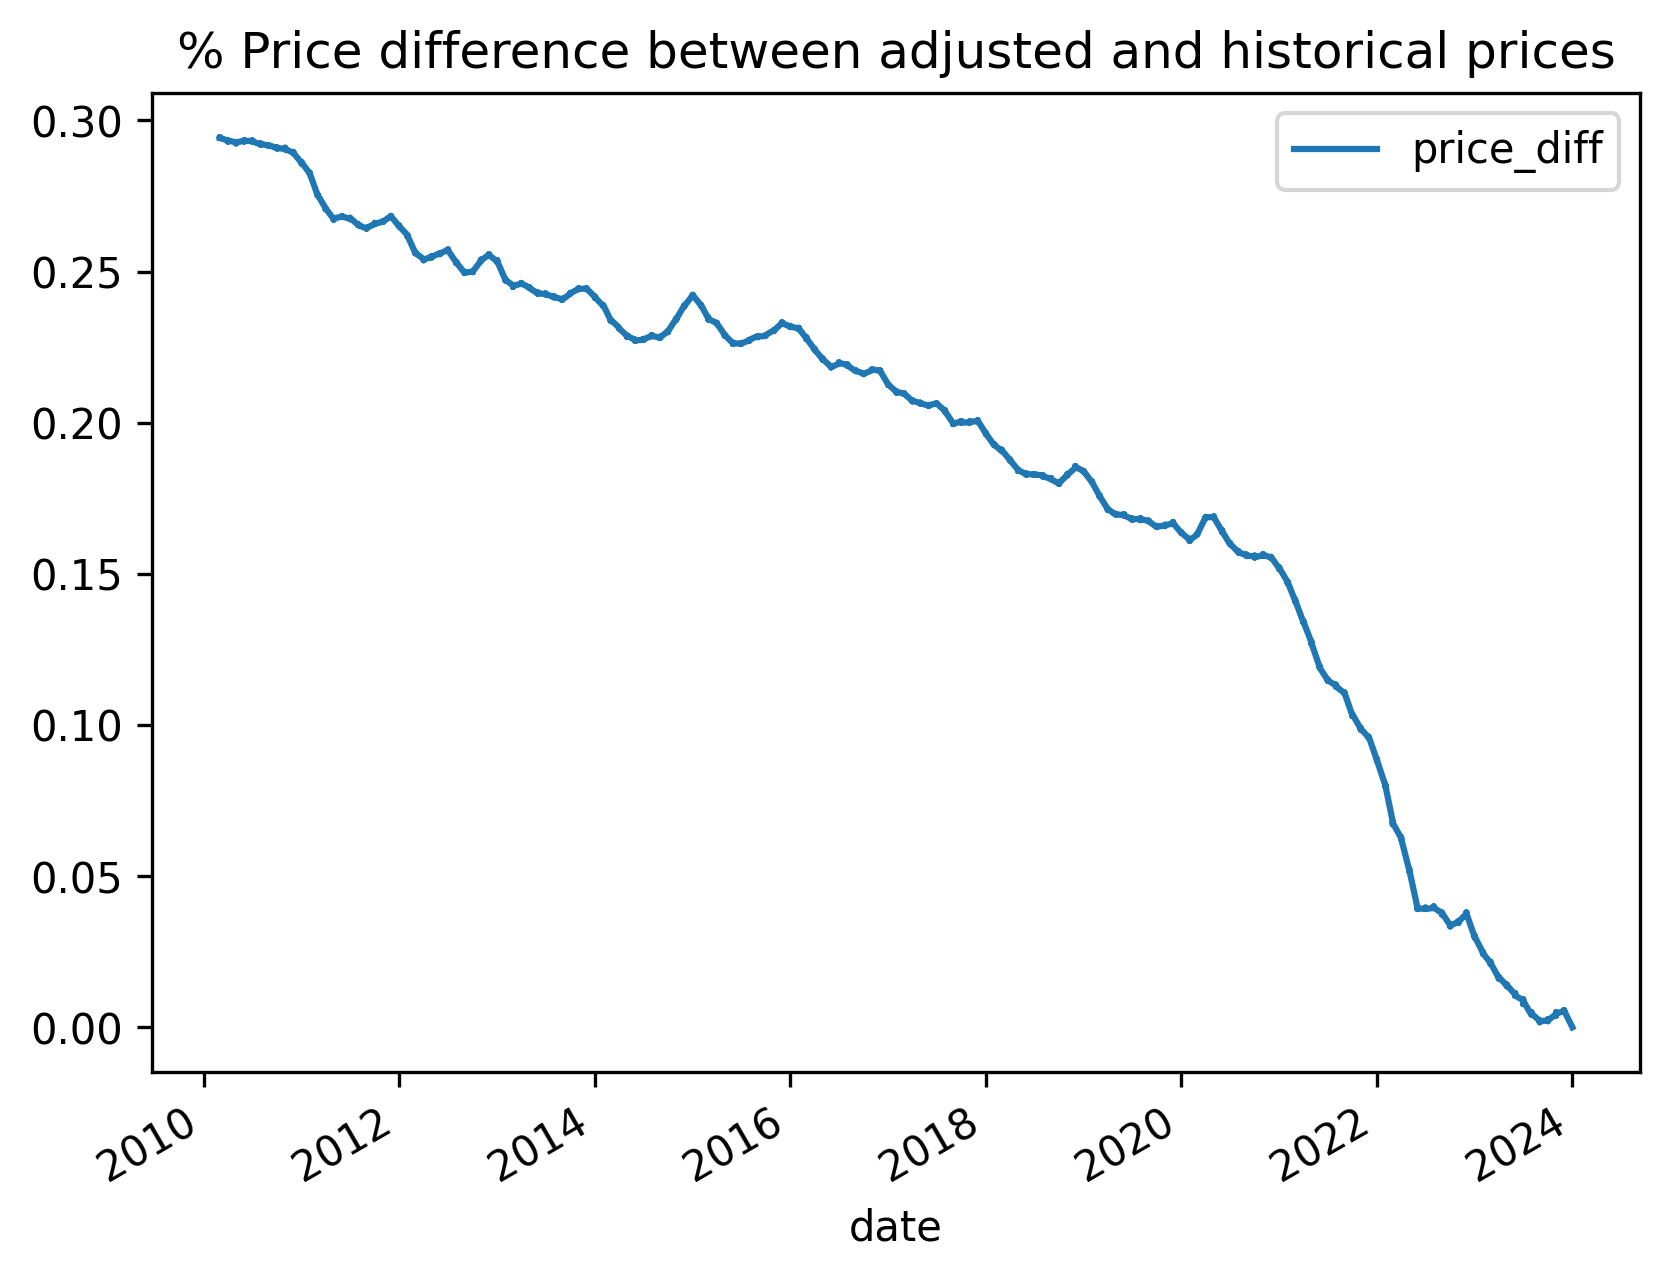

In [31]:

def load_transform_cpi(file_path: Path) -> pd.DataFrame:
    """Loads and transforms the CPI data.

    Args:
        file_path (Path): Path to the CPI data file.

    Raises:
        FileNotFoundError: If the file is not found in the specified directory.

    Returns:
        pd.DataFrame: Cleaned and transformed CPI data.
    """
    MONTH_MAP = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
    }

    try:
        cpi = pd.read_csv(file_path, usecols=['Year',
                                              'Jan', 'Feb', 'Mar',
                                              'Apr', 'May', 'Jun',
                                              'Jul', 'Aug', 'Sep',
                                              'Oct', 'Nov', 'Dec'
                                              ]
                          )
    except FileNotFoundError:
        raise FileNotFoundError("CPI file is not found in the specified directory.")

    return (cpi
            .melt(id_vars='Year', var_name='Month', value_name='cpi')
            .assign(Month=lambda x: x['Month'].map(MONTH_MAP),
                    date=lambda x: pd.to_datetime(x[['Year', 'Month']].assign(day=1)))
            .dropna()
            .drop(columns=['Year', 'Month'])
            .rename(columns={'cpi': 'consumer_price_index'})
            .sort_values('date')
            .reset_index(drop=True)
           )
    
def create_cpi_adjusted_price(df: pd.DataFrame, file_path: Path, date: str='2024-01-01') -> pd.DataFrame:
    """
    Adjusts historical price data to 2024 prices using CPI data.
    """
    cpi = load_transform_cpi(file_path)
    cpi_baseline = cpi.loc[cpi['date'] == date, 'consumer_price_index'].values[0]
    
    return (df
            .merge(cpi, left_on="review_date", right_on="date")
            .drop(columns='date')
            .assign(price_usd_adj=lambda df_: np.round(
                df_['price_value_usd_hist'] * cpi_baseline / df_['consumer_price_index'], 2)
                    )
            )
    
data_dir = Path('../../data')
cpi_path = data_dir / 'external' / 'consumer_price_index.csv'

df = (df_raw.pipe(tweak_coffee)
      .pipe(price_quantity_split)
      .pipe(clean_currency)
      .pipe(convert_to_usd)
      .pipe(create_cpi_adjusted_price, file_path=cpi_path)
)
df.sample(3)    

diff = pd.DataFrame()
diff['price_diff'] = (df['price_usd_adj'] - df['price_value_usd_hist'])/df['price_usd_adj']
diff['date'] = df['review_date']
diff.plot(x='date', y='price_diff', title='% Price difference between adjusted and historical prices')

### Converting quantities to lbs

In [100]:
to_grams_conversion = {"ounces": 28.3495231, "pounds":453.59237, "kilogram": 1000, "grams": 1}
to_lbs_conversion = {"ounces": 1/16, "pounds":1, "kilogram": 2.20462, "grams": 0.00220462}

coffee_df['quantity_in_lbs'] = ( 
    np.round(coffee_df['quantity_value'] * 
    coffee_df['quantity_unit'].map(to_lbs_conversion), 2)
)

coffee_df.sample(3)

,rating,roaster,title,blind_assessment,bottom_line,roaster_location,coordinate location,og_roaster_location,roaster_location_identifier,territorial_entity_1,...,agtron_external,agtron_ground,quantity_value,quantity_unit,price_value,price_currency,price_value_usd_hist,consumer_price_index,price_usd_2024,quantity_in_lbs
2163,95,PT's Coffee Roasting Co.,Finca El Socorro Maracaturra,"Richly sweet, balanced, intricately layered. F...",A lovely example of the big-beaned Maracaturra...,Topeka,"39.04833,-95.67804","Topeka, Kansas",Q41057,Shawnee County,...,52.0,78.0,12.0,ounces,22.50,USD,22.50,252.439,27.49,0.75
2463,92,Allegro Coffee,Congo Muungano,"Sweetly savory, high-toned. Blackberry, freesi...",An intriguing Congo cup from a cooperative tha...,Thornton,"39.9031,-104.954","Thornton, Colorado",Q579761,Adams County,...,52.0,65.0,8.0,ounces,8.99,USD,8.99,244.955,11.32,0.50
2127,92,Magnolia Coffee,Guatemala Finca San Gerardo,"Crisp, richly sweet. Magnolia, dried persimmon...","A friendly, floral-toned Guatemala cup with un...",Charlotte,"35.226944444444,-80.843333333333","Charlotte, North Carolina",Q16565,Mecklenburg County,...,52.0,72.0,12.0,ounces,15.00,USD,15.00,252.885,18.29,0.75


In [101]:
coffee_df['price_usd_2024_per_lb'] = np.round(coffee_df['price_usd_2024'] / coffee_df['quantity_in_lbs'], 2)


coffee_df['price_usd_2024_per_lb'].describe().apply("{:.2f}".format)

count    4230.00
mean       50.81
std       123.39
min         5.36
25%        25.64
50%        30.45
75%        41.41
max      5180.00
Name: price_usd_2024_per_lb, dtype: object

In [105]:
coffee_df[coffee_df['price_usd_2024_per_lb'] < 6].url

1798    https://www.coffeereview.com/review/100-guatem...
Name: url, dtype: object

In [103]:
df[df['url'].isin(coffee_df[coffee_df['price_usd_2024_per_lb'] < 0.5].url)].est_price

Series([], Name: est_price, dtype: object)

In [104]:
coffee_df[coffee_df.url.isin(coffee_df[coffee_df['price_usd_2024_per_lb'] < 0.5].url)]

,rating,roaster,title,blind_assessment,bottom_line,roaster_location,coordinate location,og_roaster_location,roaster_location_identifier,territorial_entity_1,...,agtron_ground,quantity_value,quantity_unit,price_value,price_currency,price_value_usd_hist,consumer_price_index,price_usd_2024,quantity_in_lbs,price_usd_2024_per_lb
